In [ ]:
import numpy as np

# Load the .npz file
data = np.load('dataset_features.npz')

# List all arrays within the .npz file
print(data.files)

# Access individual arrays by their names
trainset_features = data['trainset_features']
trainset_labels = data['trainset_labels']
class_labels = data['class_labels']

X = trainset_features
y = trainset_labels

X.shape

['trainset_features', 'validset_features', 'testset_features', 'trainset_labels', 'validset_labels', 'testset_labels', 'class_labels']


(280, 1280)

In [76]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_rescaled = scaler.fit_transform(X)

# Create PCA transformer
pca = PCA(n_components=None)

# Fit model to rescaled data
pca.fit(X_rescaled)

pve = pca.explained_variance_ratio_
print(f'Total number of PCA components  : {len(pve)}')
print(f'Value of first 5 PCA components : {pve[:5]}')

Total number of PCA components  : 280
Value of first 5 PCA components : [0.09543075 0.05735884 0.05263091 0.0367177  0.02781391]


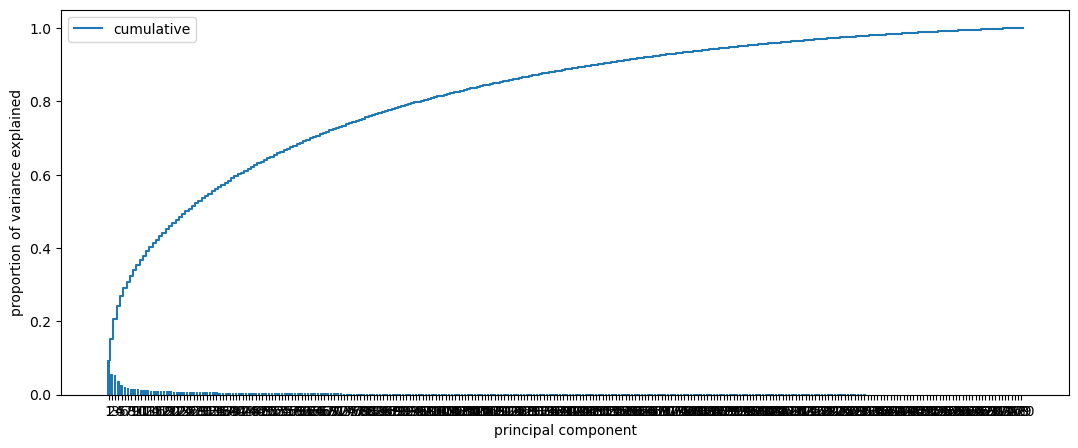

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(13,5))

# Create bar plot
xcor = np.arange(1, len(pve) + 1)  # 1,2,..,n_components
plt.bar(xcor, pve)
plt.xticks(xcor)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(
    xcor + 0.5,  # 1.5,2.5,..,n_components+0.5
    pve_cumsum,  # Cumulative sum
    label="cumulative",
)

# Add labels
plt.xlabel("principal component")
plt.ylabel("proportion of variance explained")
plt.legend()
plt.show()

In [78]:
for var_percent in np.arange(10,100,10):

    print(f'Components explaining {var_percent}% of variance: {np.argmax(pve_cumsum > var_percent/100)+1}')

Components explaining 10% of variance: 2
Components explaining 20% of variance: 3
Components explaining 30% of variance: 7
Components explaining 40% of variance: 14
Components explaining 50% of variance: 26
Components explaining 60% of variance: 41
Components explaining 70% of variance: 64
Components explaining 80% of variance: 97
Components explaining 90% of variance: 150


For explaining 100% of the variance in the dataset we need all the 152 PCA components.

In [79]:
# Create PCA transformer
pca2 = PCA(n_components=2)

# Fit model to rescaled data
X_pca_transformed = pca.transform(X_rescaled)


In [83]:
label_map = dict(zip(range(len(class_labels)),class_labels))

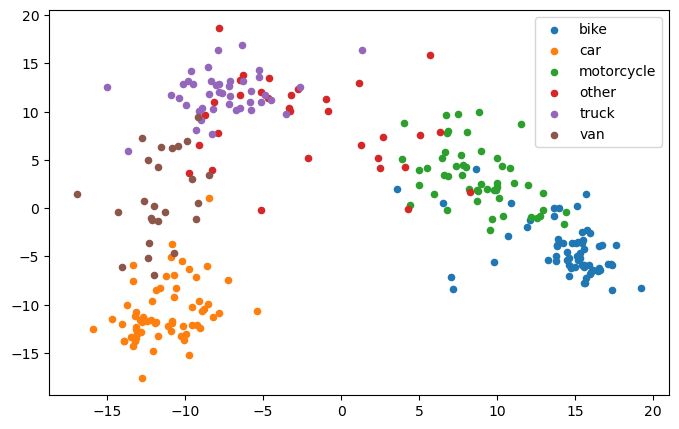

In [84]:
plt.figure(figsize=(8,5))

# Decode one-hot encoded labels to single integer labels
trainset_labels_decoded = np.argmax(trainset_labels, axis=1)

for label in range(len(label_map)):
    # Images of this digit
    idx = trainset_labels_decoded == label

    # Plot images
    plt.scatter(
        X_pca_transformed[idx, 0],
        X_pca_transformed[idx, 1],
        s=20,  # Size of each marker
        label = label_map[label]
    )
plt.legend()

We can see that just the first two PCA components aleady allows for a good separation of the categories (car, bike, motorcycle). However, for the remaining 